Ideally, we would have some external test set to test our models. How do we go about this? My first idea was to use the perfume datasets from Shuzhe, but these were mostly already included in the other sets. Of course we could still exclude them, but analysis with metrics from SIMPD paper showed that this set was not really different from the training set, so not sure if this makes sense.

In [39]:
#perhaps from the PUFFIN set? lets have a look
import pandas as pd
df = pd.read_excel('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/goog2_vpsol.xlsx')
df.columns


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CAS RN', 'NAME',
       'Preferred_name', 'IUPAC Name', 'SMILES', 'Log VP-Measured',
       'Log VP-EPISuite Prediction', 'Log VP-Prediction from our model',
       'Training/Test', 'Pv 298', 'Pv 273', 'Pv 325', 'Pv 350', 'Pv 375',
       'Sol 273', 'Sol 298', 'Sol 323', 'Sol 348', 'Sol 373'],
      dtype='object')

In [40]:
#lets standardize the smiles and query them
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem
df['SMILES_standardized'] = df['SMILES'].apply(lambda smi: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smi))))


[09:09:08] Initializing MetalDisconnector
[09:09:08] Running MetalDisconnector
[09:09:08] Initializing Normalizer
[09:09:08] Running Normalizer
[09:09:08] Running LargestFragmentChooser
[09:09:08] Fragment: COC(F)(F)C(F)(F)C(F)(F)F
[09:09:08] New largest fragment: COC(F)(F)C(F)(F)C(F)(F)F (15)
[09:09:08] Running Uncharger
[09:09:08] Initializing MetalDisconnector
[09:09:08] Running MetalDisconnector
[09:09:08] Initializing Normalizer
[09:09:08] Running Normalizer
[09:09:08] Initializing MetalDisconnector
[09:09:08] Running MetalDisconnector
[09:09:08] Initializing Normalizer
[09:09:08] Running Normalizer
[09:09:08] Running LargestFragmentChooser
[09:09:08] Fragment: CCOC(=O)C(Cl)Cc1cc(-n2nc(C)n(C(F)F)c2=O)c(F)cc1Cl
[09:09:08] New largest fragment: CCOC(=O)C(Cl)Cc1cc(-n2nc(C)n(C(F)F)c2=O)c(F)cc1Cl (40)
[09:09:08] Running Uncharger
[09:09:08] Initializing MetalDisconnector
[09:09:08] Running MetalDisconnector
[09:09:08] Initializing Normalizer
[09:09:08] Running Normalizer
[09:09:08] Ini

In [22]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
#using our standard settings for our databse cs_mdfps
config = lwreg.utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' 
config['standardization'] = standardization_lib.RemoveHs()
config['registerConformers'] = True

In [37]:
#query all the molecules
smis_registered,smis_not_registered = [],[] 
molregnos_registered = []
molregnos_to_df = []
for smi in df['SMILES_standardized']:
    query = lwreg.query(config = config, smiles=smi)
    if len(query) == 0:
        smis_not_registered.append(smi)
        molregnos_registered.append(None)
        continue
    else:
        smis_registered.append(smi)
        molregnos_registered.extend(query)
        molregnos_to_df.extend(query)
        

In [44]:
print(len(molregnos_to_df),len(df))

1572 1852


In [45]:
df['molregno'] = molregnos_registered  

In [46]:
print(len(smis_registered),len(smis_not_registered))

1572 280


In [26]:
import psycopg2
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()

In [27]:
#for molregno in molregnos_already_registered, check if there is an entry in cs_mdfps_schema.experimental_data

query = "SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno = ANY(%s)"
cur.execute(query, (molregnos_registered,))
rows = cur.fetchall()
print(len(rows))
#get these datapoints
datapoints = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])
print(datapoints.head())

1550
   molregno  vp_log10_pa      source metadata
0     15667       -3.240  Naef_Acree       {}
1       412       -2.874  Naef_Acree       {}
2      2965       -4.876  Naef_Acree       {}
3       351       -0.587  Naef_Acree       {}
4     15763       -0.644  Naef_Acree       {}


In [28]:
from rdkit.Chem import rdFingerprintGenerator

def get_fps(ms, generator=None):
    " generate fingerprints for a set of molecules "
    if generator is None:
        #generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=6)
        generator = rdFingerprintGenerator.GetMorganGenerator(radius=3)
    fps = [generator.GetFingerprint(x) for x in ms]
    return fps

In [50]:
df['mol'] = [Chem.MolFromSmiles(x) for x in df['SMILES_standardized']]
fps = get_fps(df.mol)
df['fps'] = fps
plt.hist(df['fps'].apply(lambda x: len(x)))
plt.xscale('log')

In [30]:
import bisect

import numpy as np
import pandas as pd
from rdkit import Chem
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import random
from sklearn.model_selection import train_test_split
def get_distance_cdf(fps1,
                     fps2,
                     removeSelf=False,
                     vals=np.arange(0, 1.01, 0.01)):
    ' finds the CDF for the closest member of fps2 to each element of fps1 '
    nbrds = []
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        nbrds.append(min(ds))
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res
def get_dissim_cdf(fps1,
                   fps2,
                   frac=0.2,
                   removeSelf=False,
                   vals=np.arange(0, 1.01, 0.01)):
    ' finds the CDF for the X percentile most-distant member of fps2 to each element of fps1 '
    nbrds = []
    refPos = int(frac * len(fps2))
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        nbrds.append(ds[refPos])
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res
def get_randomdist_cdf(fps1,
                       fps2,
                       distThresh=0.8,
                       removeSelf=False,
                       vals=np.arange(0, 1.01, 0.01)):
    ''' CDF of number of points in fps2 which are greater than distThresh 
      from each point in fps1 
    '''
    nbrds = []
    nfps2 = len(fps2)
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        pos = bisect.bisect_left(ds, distThresh)
        nbrds.append((nfps2 - pos) / nfps2)
        nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res

def get_relateddist_cdf(fps1,
                        fps2,
                        distThresh=0.65,
                        removeSelf=False,
                        vals=np.arange(0, 1.01, 0.01)):
    ''' CDF of number of points in fps2 which are less than distThresh 
      from each point in fps1 
    '''
    nbrds = []
    nfps2 = len(fps2)
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        nbrds.append(bisect.bisect_left(ds, distThresh) / nfps2)
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)

    return res

def modified_spatial_stats(testfps,
                           trainfps,
                           vals=np.arange(0, 1.01, 0.01)):
    ' calculates F using closest member of train to test instead of vice-versa '
    g_vals = get_distance_cdf(testfps, testfps, removeSelf=True, vals=vals)
    tfps = trainfps
    bootstrap = [
        tfps[x]
        for x in [random.randint(0,
                                 len(tfps) - 1) for x in range(len(tfps))]
    ]
    f_vals = get_distance_cdf(testfps, bootstrap, vals=vals)
    s_vals = [f - g for f, g in zip(f_vals, g_vals)]
    return vals, g_vals, f_vals, s_vals

In [51]:
df_train = pd.read_csv('../data_curation/mols_mdfp_physchem_features.csv')
df_train['mol'] = [Chem.MolFromMolBlock(x) for x in df_train['molblock']]
fps = get_fps(df_train.mol)
df_train['fps'] = fps
df_test = df[~df['SMILES_standardized'].isin(smis_registered)]
print(len(df_train),len(df_test))

3231 280


In [52]:
vals_lao, g_vals_lao, f_vals_lao, s_vals_lao = modified_spatial_stats(df_train['fps'].tolist(), df_test['fps'].tolist())
#print sums
print(sum(g_vals_lao), sum(f_vals_lao), sum(s_vals_lao))

59.36645001547507 30.785824822036528 -28.580625193438554


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


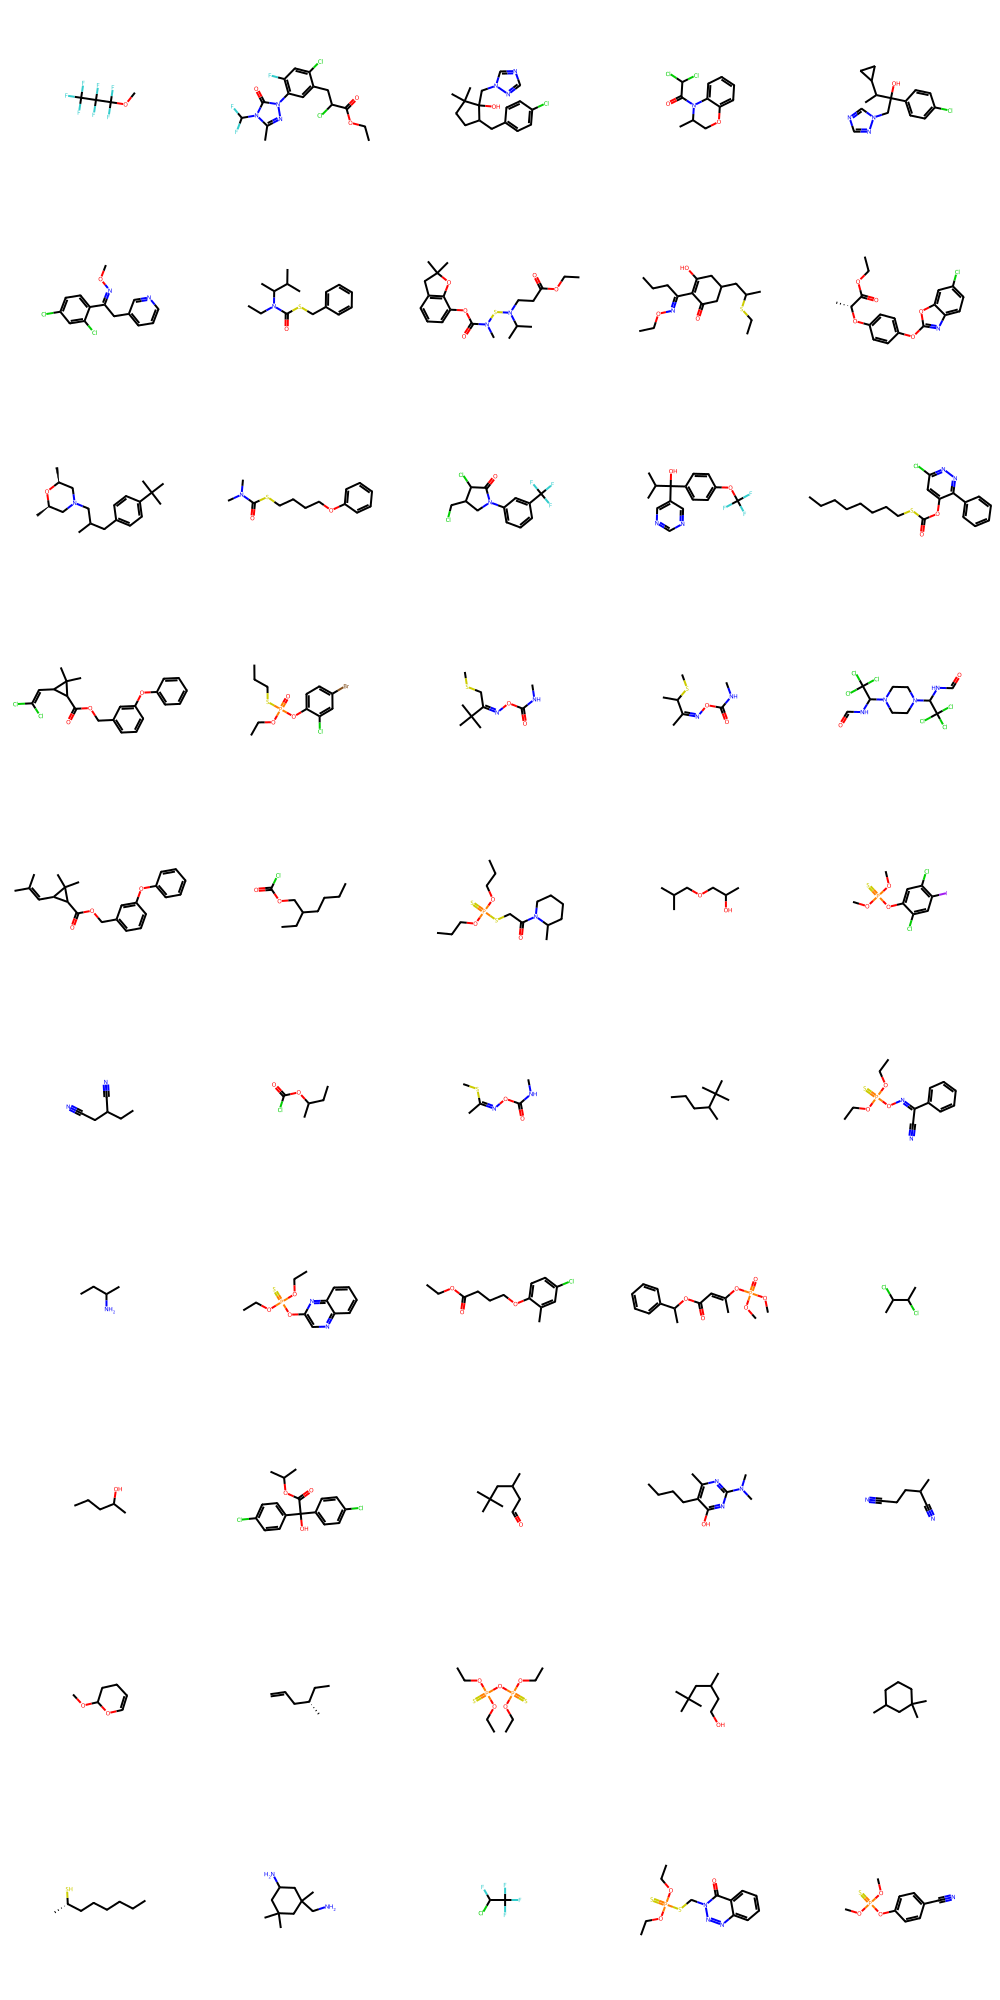

In [53]:
#that could work! what do the mols look like?
from rdkit.Chem import Draw
Draw.MolsToGridImage(df_test['mol'].tolist(), molsPerRow=5, subImgSize=(200, 200))

In [56]:
molregnos_puffin = df['molregno'].tolist()
molregnos_puffin = [m for m in molregnos_puffin if m is not None]
molregnos_puffin = list(set(molregnos_puffin))

<Axes: >

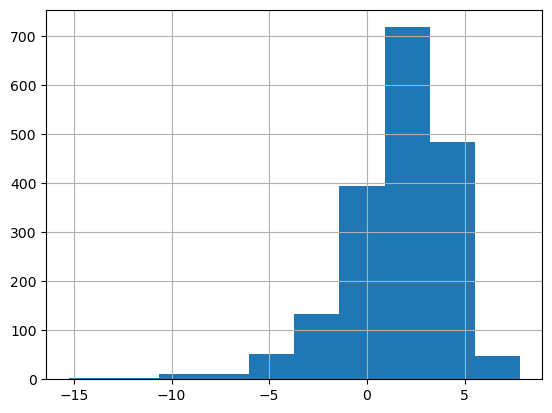

In [73]:
df.columns
#pv is probably in mmHg? make column with Pa, then log10Pa
# df['pv_298_Pa'] = df['Pv 298'] * 133.322
df['vp_log10_pa'] = df['Pv 298'].apply(lambda x: np.log10(x))
df['vp_log10_pa'].hist()

In [74]:
#look at overlapping points to see if we can trust this data
molregnos_naef_acree_opera = df_train['molregno'].tolist()
molregnos_naef_acree_opera = [m for m in molregnos_naef_acree_opera if m is not None]
molregnos_naef_acree_opera = list(set(molregnos_naef_acree_opera))

overlapping_molregnos = [m for m in molregnos_puffin if m in molregnos_naef_acree_opera]
print(len(overlapping_molregnos))

1502


In [75]:
#for these, get the experimental data from both sources, compare
val_opera_naef_acree,val_PUFFIN = [],[]
for molregno in overlapping_molregnos:
    #get val for vp_log10_pa from df for this molregno
    val_PUFFIN.append(df[df['molregno'] == molregno]['vp_log10_pa'].values[0])
    #get val for vp_log10_pa from df_train for this molregno
    val_opera_naef_acree.append(df_train[df_train['molregno'] == molregno]['vp_log10_pa'].values[0])
    

(array([[  1.,   0.,   5.,  11.,  41., 128., 349., 551., 377.,  39.],
        [  0.,   0.,   8.,  20.,  75., 166., 323., 510., 363.,  37.]]),
 array([-14.6245568 , -12.37922291, -10.13388902,  -7.88855513,
         -5.64322124,  -3.39788736,  -1.15255347,   1.09278042,
          3.33811431,   5.5834482 ,   7.82878209]),
 <a list of 2 BarContainer objects>)

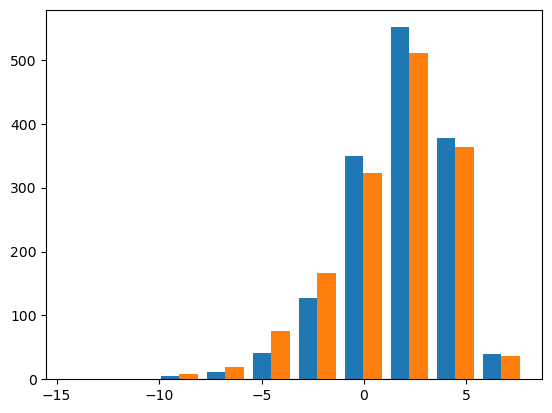

In [76]:
#binned histogram
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist([val_PUFFIN,val_opera_naef_acree], bins=10, label=['PUFFIN','OPERA/NAEF/ACREE'])

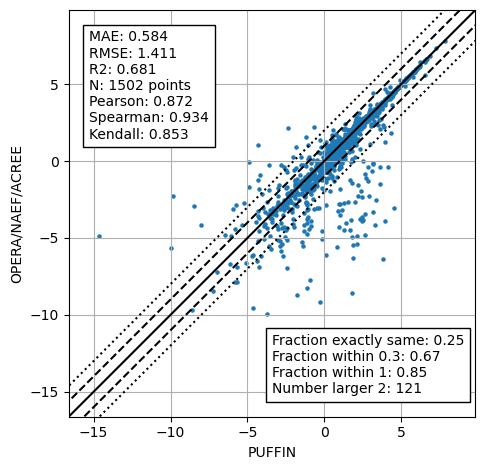

In [77]:
#scatter
fig, ax = plt.subplots()
# Scatter plot
ax.scatter(val_PUFFIN,val_opera_naef_acree, s=5)
ax.set_xlabel('PUFFIN')
ax.set_ylabel('OPERA/NAEF/ACREE')

# Make square
ax.set_aspect('equal', 'box')

# Add diagonal line
ax.plot([-20, 10], [-20, 10], color='black')

# Add dashed lines at 1 log unit difference
ax.plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
ax.plot([-21, 9], [-20, 10], color='black', linestyle='dashed')

# Add dashed lines at 2 log unit difference
ax.plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
ax.plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
# Calculate metrics


# Add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

mae = mean_absolute_error(val_PUFFIN, val_opera_naef_acree)
rmse = np.sqrt(mean_squared_error(val_PUFFIN, val_opera_naef_acree))
r2 = r2_score(val_PUFFIN, val_opera_naef_acree)
pearson = pearsonr(val_PUFFIN, val_opera_naef_acree)
spearman = spearmanr(val_PUFFIN, val_opera_naef_acree)
kendall = kendalltau(val_PUFFIN, val_opera_naef_acree)


# Also get: fraction exactly the same (diff smaller than 0.01), fraction within 0.3 log unit,
# fraction within 1 log units and number of points with diff larger than 2 log units

diff = np.array(val_PUFFIN) - np.array(val_opera_naef_acree)
diff_abs = np.abs(diff)

fraction_exactly_same = len(diff_abs[diff_abs < 0.01]) / len(diff_abs)
fraction_within_03 = len(diff_abs[diff_abs < 0.3]) / len(diff_abs)
fraction_within_1 = len(diff_abs[diff_abs < 1]) / len(diff_abs)
number_larger_2 = len(diff_abs[diff_abs > 2])

# Add metrics and number of points to plot
text_box = ax.text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {} points\nPearson: {:.3f}\nSpearman: {:.3f}\nKendall: {:.3f}'.format(mae, rmse, r2, len(val_PUFFIN), pearson[0], spearman[0], kendall[0]), transform=ax.transAxes, verticalalignment='top')
text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

# Similar box in bottom right with fraction exactly the same, fraction within 0.3 log unit,
# fraction within 1 log units and number of points with diff larger than 2 log units
text_box = ax.text(0.50, 0.05, 'Fraction exactly same: {:.2f}\nFraction within 0.3: {:.2f}\nFraction within 1: {:.2f}\nNumber larger 2: {}'.format(fraction_exactly_same, fraction_within_03, fraction_within_1, number_larger_2), transform=ax.transAxes, verticalalignment='bottom')
text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

ax.grid()
minimum = min(min(val_PUFFIN), min(val_opera_naef_acree))
maximum = max(max(val_PUFFIN), max(val_opera_naef_acree))

# Set limit
ax.set_xlim(minimum - 2, maximum + 2)
ax.set_ylim(minimum - 2, maximum + 2)

plt.tight_layout()
plt.show()

In [78]:
#nope not going to trust this dataset. 

okay lets think for a bit here; what would you like to see if you would be reading a paper about VP prediction? So of course, ideally a standard benchmarking set, but I don't think that exists. Then there are a few other things we can do. If we don't really care about the model, we can just do a random split, and add some baselines to see how much a certain representation actually adds. 

Alternatively, if we want to compare it to models that we can not retrain, we could see if we coulde use the same splits as they do. For example, OPERA reports both fivevold CV (75/25), and a random split (75/25). We could do this same split and see how we perform there so we can compare it. We could either do this with the same training set, or with the 'augmented' set (also adding extra datapoints from the Naef and Acree paper). However, they only report R2 and RMSEP, but I guess we can get the actual predictions and calculate more relevant properties ourselves. 


Aside: we could also do a multitask learning for OPERA? Don't think it has been done before